# Analyzing Neighborhoods in Mumbai, India for Starting a Restaurant

In [1]:
#Importing required libraries
!pip install geopy
!pip install geocoder
!pip install folium

import numpy as np
import pandas as pd
import json
from geopy.geocoders import Nominatim
import geocoder
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.json import json_normalize
from sklearn.metrics import silhouette_score

%matplotlib notebook

print('Required libraries imported.')

     |████████████████████████████████| 98 kB 11.1 MB/s eta 0:00:01
     |████████████████████████████████| 94 kB 5.3 MB/s  eta 0:00:01
Required libraries imported.


## Data Retrieval

In [2]:
# Scraping data from https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai and reading it into a dataframe.
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai')[-1]
df.rename(columns={'Area': 'Neighborhood'}, inplace=True)
df.head(10)

,Neighborhood,Location,Latitude,Longitude
0,Amboli,"Andheri,Western Suburbs",19.129300,72.843400
1,Chakala,"Andheri,Western Suburbs",19.111388,72.860833
2,D.N. Nagar,"Andheri,Western Suburbs",19.124085,72.831373
3,Four Bungalows,"Andheri,Western Suburbs",19.124714,72.827210
4,Lokhandwala,"Andheri,Western Suburbs",19.130815,72.829270
5,Marol,"Andheri,Western Suburbs",19.119219,72.882743
6,Sahar,"Andheri,Western Suburbs",19.098889,72.867222
7,Seven Bungalows,"Andheri,Western Suburbs",19.129052,72.817018
8,Versova,"Andheri,Western Suburbs",19.120000,72.820000
9,Mira Road,"Mira-Bhayandar,Western Suburbs",19.284167,72.871111


## Data Wrangling

In [3]:
# Different values for Location present in the Location column
df['Location'].value_counts()

South Mumbai                       30
Andheri,Western Suburbs             9
Western Suburbs                     5
Eastern Suburbs                     4
Powai,Eastern Suburbs               3
Ghatkopar,Eastern Suburbs           3
Mira-Bhayandar,Western Suburbs      3
Bandra,Western Suburbs              3
Kandivali West,Western Suburbs      3
Khar,Western Suburbs                2
Kalbadevi,South Mumbai              2
Vasai,Western Suburbs               2
Malad,Western Suburbs               2
Mumbai                              2
Harbour Suburbs                     2
Goregaon,Western Suburbs            2
Borivali (West),Western Suburbs     2
Govandi,Harbour Suburbs             1
Colaba,South Mumbai                 1
Tardeo,South Mumbai                 1
Kurla,Eastern Suburbs               1
Trombay,Harbour Suburbs             1
Sanctacruz,Western Suburbs          1
Antop Hill,South Mumbai             1
Kandivali East,Western Suburbs      1
Vile Parle,Western Suburbs          1
Dadar,South 

In [4]:
#Clean the Location column
df['Location'] = df['Location'].apply(lambda x: x.split(',')[-1])
df.head(10)

,Neighborhood,Location,Latitude,Longitude
0,Amboli,Western Suburbs,19.129300,72.843400
1,Chakala,Western Suburbs,19.111388,72.860833
2,D.N. Nagar,Western Suburbs,19.124085,72.831373
3,Four Bungalows,Western Suburbs,19.124714,72.827210
4,Lokhandwala,Western Suburbs,19.130815,72.829270
5,Marol,Western Suburbs,19.119219,72.882743
6,Sahar,Western Suburbs,19.098889,72.867222
7,Seven Bungalows,Western Suburbs,19.129052,72.817018
8,Versova,Western Suburbs,19.120000,72.820000
9,Mira Road,Western Suburbs,19.284167,72.871111


In [5]:
#Values in Location column
df['Location'].value_counts()

South Mumbai       39
Western Suburbs    36
Eastern Suburbs    12
Harbour Suburbs     4
Mumbai              2
Name: Location, dtype: int64

In [6]:
#Display the dataframe
df

,Neighborhood,Location,Latitude,Longitude
0,Amboli,Western Suburbs,19.129300,72.843400
1,Chakala,Western Suburbs,19.111388,72.860833
2,D.N. Nagar,Western Suburbs,19.124085,72.831373
3,Four Bungalows,Western Suburbs,19.124714,72.827210
4,Lokhandwala,Western Suburbs,19.130815,72.829270
...,...,...,...,...
88,Parel,South Mumbai,18.990000,72.840000
89,Gowalia Tank,South Mumbai,18.962450,72.809703
90,Dava Bazaar,South Mumbai,18.946882,72.831362
91,Dharavi,Mumbai,19.040208,72.850850


In [8]:
#Reconfirm coordinates using Geocoder
df['Latitude1'] = None
df['Longitude1'] = None

for i, neigh in enumerate(df['Neighborhood']):
    lat_lng_coords = None
    
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Mumbai, India'.format(neigh))
        lat_lng_coords = g.latlng
    
    if lat_lng_coords:
        latitude = lat_lng_coords[0]
        longitude = lat_lng_coords[1]
    
    df.loc[i, 'Latitude1'] = latitude
    df.loc[i, 'Longitude1'] = longitude

df.head(10)

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1
0,Amboli,Western Suburbs,19.129300,72.843400,19.12906,72.84644
1,Chakala,Western Suburbs,19.111388,72.860833,19.10836,72.86233
2,D.N. Nagar,Western Suburbs,19.124085,72.831373,19.12505,72.83248
3,Four Bungalows,Western Suburbs,19.124714,72.827210,19.12638,72.8242
4,Lokhandwala,Western Suburbs,19.130815,72.829270,19.14321,72.82497
5,Marol,Western Suburbs,19.119219,72.882743,19.11905,72.88281
6,Sahar,Western Suburbs,19.098889,72.867222,19.105445,72.860602
7,Seven Bungalows,Western Suburbs,19.129052,72.817018,19.12858,72.82141
8,Versova,Western Suburbs,19.120000,72.820000,19.13769,72.81348
9,Mira Road,Western Suburbs,19.284167,72.871111,19.265623,72.870643


In [9]:
#We create new columns to see the difference between coordinate values obtained from wikipedia and those obtained from geocoder. 
#We will take the absolute difference between these values and store them in our dataframe.
df['Latdiff'] = abs(df['Latitude'] - df['Latitude1'])
df['Longdiff'] = abs(df['Longitude'] - df['Longitude1'])
df.head(10)

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1,Latdiff,Longdiff
0,Amboli,Western Suburbs,19.129300,72.843400,19.12906,72.84644,0.00024,0.00304
1,Chakala,Western Suburbs,19.111388,72.860833,19.10836,72.86233,0.003028,0.001497
2,D.N. Nagar,Western Suburbs,19.124085,72.831373,19.12505,72.83248,0.000965,0.001107
3,Four Bungalows,Western Suburbs,19.124714,72.827210,19.12638,72.8242,0.001666,0.00301
4,Lokhandwala,Western Suburbs,19.130815,72.829270,19.14321,72.82497,0.012395,0.0043
5,Marol,Western Suburbs,19.119219,72.882743,19.11905,72.88281,0.000169,0.000067
6,Sahar,Western Suburbs,19.098889,72.867222,19.105445,72.860602,0.006556,0.00662
7,Seven Bungalows,Western Suburbs,19.129052,72.817018,19.12858,72.82141,0.000472,0.004392
8,Versova,Western Suburbs,19.120000,72.820000,19.13769,72.81348,0.01769,0.00652
9,Mira Road,Western Suburbs,19.284167,72.871111,19.265623,72.870643,0.018544,0.000468


In [10]:
#Replace the values with the coordinates obtained from geocoder if the absolute difference is more than 0.001
df.loc[df.Latdiff>0.001, 'Latitude'] = df.loc[df.Latdiff>0.001, 'Latitude1']
df.loc[df.Longdiff>0.001, 'Longitude'] = df.loc[df.Longdiff>0.001, 'Longitude1']
df.head(10)

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1,Latdiff,Longdiff
0,Amboli,Western Suburbs,19.1293,72.84644,19.12906,72.84644,0.00024,0.00304
1,Chakala,Western Suburbs,19.10836,72.86233,19.10836,72.86233,0.003028,0.001497
2,D.N. Nagar,Western Suburbs,19.124085,72.83248,19.12505,72.83248,0.000965,0.001107
3,Four Bungalows,Western Suburbs,19.12638,72.8242,19.12638,72.8242,0.001666,0.00301
4,Lokhandwala,Western Suburbs,19.14321,72.82497,19.14321,72.82497,0.012395,0.0043
5,Marol,Western Suburbs,19.119219,72.882743,19.11905,72.88281,0.000169,0.000067
6,Sahar,Western Suburbs,19.105445,72.860602,19.105445,72.860602,0.006556,0.00662
7,Seven Bungalows,Western Suburbs,19.129052,72.82141,19.12858,72.82141,0.000472,0.004392
8,Versova,Western Suburbs,19.13769,72.81348,19.13769,72.81348,0.01769,0.00652
9,Mira Road,Western Suburbs,19.265623,72.871111,19.265623,72.870643,0.018544,0.000468


In [11]:
df.where(df['Latitude']==df['Latitude1'])

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1,Latdiff,Longdiff
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Chakala,Western Suburbs,19.10836,72.86233,19.10836,72.86233,0.003028,0.001497
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Four Bungalows,Western Suburbs,19.12638,72.8242,19.12638,72.8242,0.001666,0.00301
4,Lokhandwala,Western Suburbs,19.14321,72.82497,19.14321,72.82497,0.012395,0.0043
...,...,...,...,...,...,...,...,...
88,Parel,South Mumbai,18.99568,72.84,18.99568,72.83912,0.00568,0.00088
89,Gowalia Tank,South Mumbai,18.96446,72.81117,18.96446,72.81117,0.00201,0.001467
90,Dava Bazaar,South Mumbai,19.1314,72.92696,19.1314,72.92696,0.184518,0.095598
91,Dharavi,Mumbai,19.04674,72.85461,19.04674,72.85461,0.006532,0.00376


In [12]:
df.where(df['Longitude']==df['Longitude1'])

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1,Latdiff,Longdiff
0,Amboli,Western Suburbs,19.1293,72.84644,19.12906,72.84644,0.00024,0.00304
1,Chakala,Western Suburbs,19.10836,72.86233,19.10836,72.86233,0.003028,0.001497
2,D.N. Nagar,Western Suburbs,19.124085,72.83248,19.12505,72.83248,0.000965,0.001107
3,Four Bungalows,Western Suburbs,19.12638,72.8242,19.12638,72.8242,0.001666,0.00301
4,Lokhandwala,Western Suburbs,19.14321,72.82497,19.14321,72.82497,0.012395,0.0043
...,...,...,...,...,...,...,...,...
88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,Gowalia Tank,South Mumbai,18.96446,72.81117,18.96446,72.81117,0.00201,0.001467
90,Dava Bazaar,South Mumbai,19.1314,72.92696,19.1314,72.92696,0.184518,0.095598
91,Dharavi,Mumbai,19.04674,72.85461,19.04674,72.85461,0.006532,0.00376


In [13]:
#Drop the columns that are no longer useful
df.drop(['Latitude1', 'Longitude1', 'Latdiff', 'Longdiff'], axis=1, inplace=True)
df.head(10)

,Neighborhood,Location,Latitude,Longitude
0,Amboli,Western Suburbs,19.1293,72.84644
1,Chakala,Western Suburbs,19.10836,72.86233
2,D.N. Nagar,Western Suburbs,19.124085,72.83248
3,Four Bungalows,Western Suburbs,19.12638,72.8242
4,Lokhandwala,Western Suburbs,19.14321,72.82497
5,Marol,Western Suburbs,19.119219,72.882743
6,Sahar,Western Suburbs,19.105445,72.860602
7,Seven Bungalows,Western Suburbs,19.129052,72.82141
8,Versova,Western Suburbs,19.13769,72.81348
9,Mira Road,Western Suburbs,19.265623,72.871111


## Data Visualization

In [14]:
neighborhoods_mumbai = df.groupby('Location')['Neighborhood'].nunique()
neighborhoods_mumbai

Location
Eastern Suburbs    12
Harbour Suburbs     4
Mumbai              2
South Mumbai       39
Western Suburbs    36
Name: Neighborhood, dtype: int64

<IPython.core.display.Javascript object>


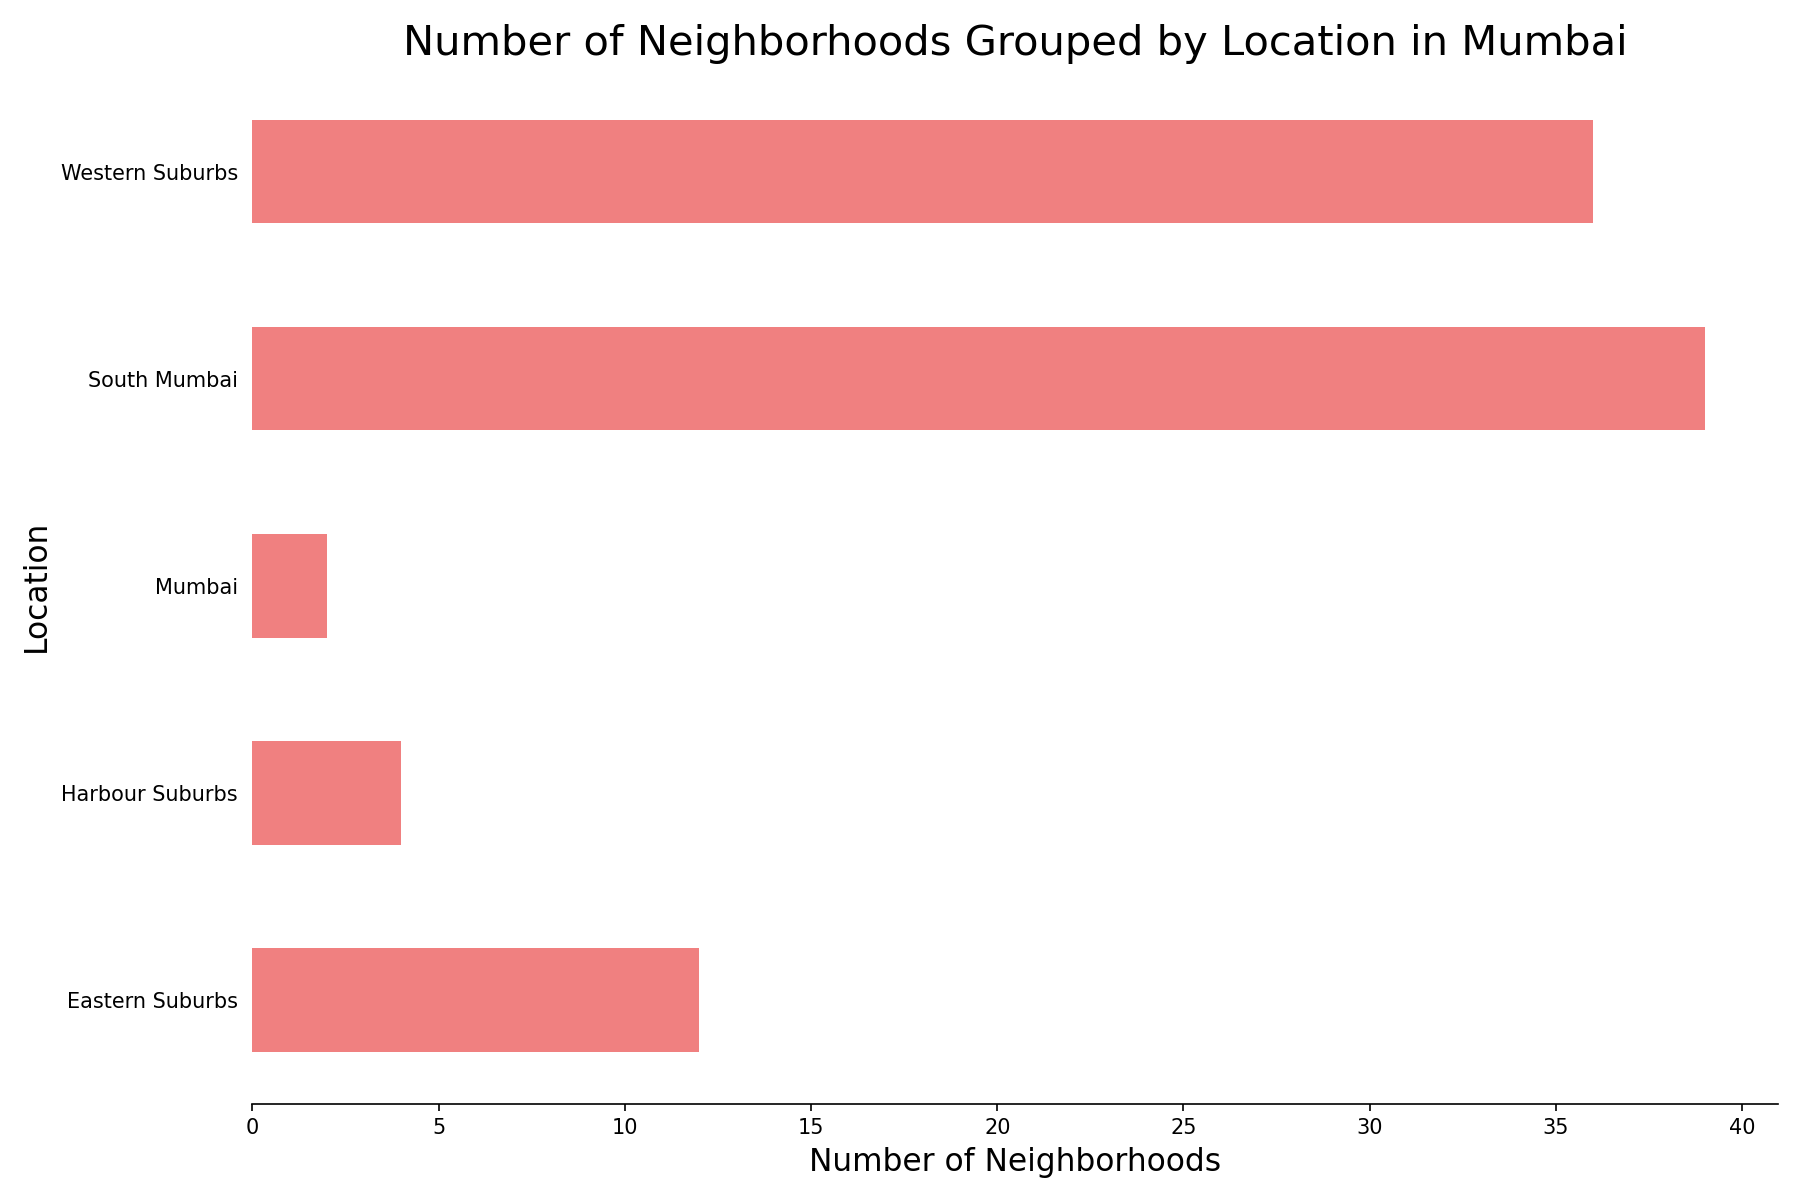

In [15]:
#Plot the data
fig = plt.figure(figsize=(12,8))

ax = neighborhoods_mumbai.plot(kind='barh', color='lightcoral')
ax.set_title('Number of Neighborhoods Grouped by Location in Mumbai', fontsize=20)
ax.set_xlabel('Number of Neighborhoods', fontsize=15)
ax.set_ylabel('Location', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(which='major', left=False)

fig.tight_layout()

#### We can see that South Mumbai and Western Suburbs have the greatest number of neighborhoods. 
#### One of the locations is because the neighborhoods contained in this location are located at the outskirts of Mumbai and thus have been grouped as just Mumbai.

#### We will visualize the neighborhoods on a map using Folium. 

In [22]:
#Obtain the geographical coordinates of Mumbai using GeoPy
address = 'Mumbai, IN'
geolocator = Nominatim(user_agent="1373923059")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical co-ordinates of Mumbai are {}, {}.'.format(latitude, longitude))

The geograpical co-ordinates of Mumbai are 19.0759899, 72.8773928.


In [23]:
#Map Plot
map_mum = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, location, neighborhood in zip(df['Latitude'], df['Longitude'], df['Location'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mum)  
    
map_mum

## Using Foursquare API

In [25]:
#Exploring first neighbourhood in our dataframe using Foursquare API
neighborhood_name = df.loc[0, 'Neighborhood']
neighborhood_lat = df.loc[0, 'Latitude']
neighborhood_long = df.loc[0, 'Longitude']

print("The neighborhood is {} and it's geographical coordinates are {} latitude and {} longitude".format(neighborhood_name,
                                                                                                        neighborhood_lat, neighborhood_long))

The neighborhood is Amboli and it's geographical coordinates are 19.1293 latitude and 72.84644000000003 longitude


In [31]:
#Client ID and Client Secret
CLIENT_ID= 'AWQZGOJ0FF4TOTS2K42P1Q0PP125QJDHLUXNEOIYPYN2ZRQB'
CLIENT_SECRET= 'TYQ12OZHGYDJNGK45HHNQHNUOP5XPRZOR1PO5DKTHNDK0LA5'
VERSION= '20180602'

#Top 200 venues near Amboli with a radius of 1000m or 1km
LIMIT = 200
radius = 1000

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_lat, 
    neighborhood_long, 
    radius, 
    LIMIT)

In [32]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '61163f978136f3203a37f82f'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Jogeshwari West',
  'headerFullLocation': 'Jogeshwari West, Mumbai',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 27,
  'suggestedBounds': {'ne': {'lat': 19.13830000900001,
    'lng': 72.85594823590122},
   'sw': {'lat': 19.120299990999992, 'lng': 72.83693176409884}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4d10d39b7177b1f7d2c75322',
       'name': 'Cafe Arfa',
       'location': {'address': 'S V Road',
        'crossStreet': 'Andheri West',
        'lat': 19.12893009094341,
        'lng': 72.84714004510111,
        'labeledLatLngs': [{'label'

In [33]:
#Extract the categories of venues
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [34]:
#Clean the JSON obtained using the GET method and store our results in a dataframe
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

<ipython-input-34-aa5f82cf9b9c>:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues)


,name,categories,lat,lng
0,Cafe Arfa,Indian Restaurant,19.128930,72.847140
1,"5 Spice , Bandra",Chinese Restaurant,19.130421,72.847206
2,Jaffer Bhai's Delhi Darbar,Mughlai Restaurant,19.137714,72.845909
3,Narayan Sandwich,Sandwich Place,19.121398,72.850270
4,Shawarma Factory,Falafel Restaurant,19.124591,72.840398


In [35]:
print("{} venues were returned for {} by Foursquare".format(len(nearby_venues), neighborhood_name))

27 venues were returned for Amboli by Foursquare


## Generalizing Foursquare API

In [36]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [37]:
mum_venues = getNearbyVenues(names=df['Neighborhood'], latitudes=df['Latitude'], longitudes=df['Longitude'], radius=radius)

Amboli
Chakala
D.N. Nagar
Four Bungalows
Lokhandwala
Marol
Sahar
Seven Bungalows
Versova
Mira Road
Bhayandar
Uttan
Bandstand Promenade
Kherwadi
Pali Hill
I.C. Colony
Gorai
Dahisar
Aarey Milk Colony
Bangur Nagar
Jogeshwari West
Juhu
Charkop
Poisar
Mahavir Nagar
Thakur village
Pali Naka
Khar Danda
Dindoshi
Sunder Nagar
Kalina
Naigaon
Nalasopara
Virar
Irla
Vile Parle
Bhandup
Amrut Nagar
Asalfa
Pant Nagar
Kanjurmarg
Nehru Nagar
Nahur
Chandivali
Hiranandani Gardens
Indian Institute of Technology Bombay campus
Vidyavihar
Vikhroli
Chembur
Deonar
Mankhurd
Mahul
Agripada
Altamount Road
Bhuleshwar
Breach Candy
Carmichael Road
Cavel
Churchgate
Cotton Green
Cuffe Parade
Cumbala Hill
Currey Road
Dhobitalao
Dongri
Kala Ghoda
Kemps Corner
Lower Parel
Mahalaxmi
Mahim
Malabar Hill
Marine Drive
Marine Lines
Mumbai Central
Nariman Point
Prabhadevi
Sion
Walkeshwar
Worli
C.G.S. colony
Dagdi Chawl
Navy Nagar
Hindu colony
Ballard Estate
Chira Bazaar
Fanas Wadi
Chor Bazaar
Matunga
Parel
Gowalia Tank
Dava Baza

In [38]:
print(mum_venues.shape)
mum_venues.head(10)

(3693, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Amboli,19.1293,72.84644,Cafe Arfa,19.128930,72.847140,Indian Restaurant
1,Amboli,19.1293,72.84644,"5 Spice , Bandra",19.130421,72.847206,Chinese Restaurant
2,Amboli,19.1293,72.84644,Jaffer Bhai's Delhi Darbar,19.137714,72.845909,Mughlai Restaurant
3,Amboli,19.1293,72.84644,Narayan Sandwich,19.121398,72.850270,Sandwich Place
4,Amboli,19.1293,72.84644,Shawarma Factory,19.124591,72.840398,Falafel Restaurant
5,Amboli,19.1293,72.84644,Persia Darbar,19.136952,72.846822,Indian Restaurant
6,Amboli,19.1293,72.84644,Domino's Pizza,19.131000,72.848000,Pizza Place
7,Amboli,19.1293,72.84644,Garden Court,19.127188,72.837478,Indian Restaurant
8,Amboli,19.1293,72.84644,Subway,19.127860,72.844461,Sandwich Place
9,Amboli,19.1293,72.84644,Courtyard Restaurant & Bar,19.131692,72.837269,Asian Restaurant


In [39]:
mum_venues.groupby('Neighborhood', as_index=False).count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Aarey Milk Colony,13,13,13,13,13,13
1,Agripada,29,29,29,29,29,29
2,Altamount Road,66,66,66,66,66,66
3,Amboli,27,27,27,27,27,27
4,Amrut Nagar,12,12,12,12,12,12
...,...,...,...,...,...,...,...
88,Vikhroli,8,8,8,8,8,8
89,Vile Parle,74,74,74,74,74,74
90,Virar,16,16,16,16,16,16
91,Walkeshwar,15,15,15,15,15,15


In [40]:
print("There are {} unique categories".format(mum_venues['Venue Category'].nunique()))

There are 226 unique categories


#### Analyzing each neighborhood

In [41]:
mum_onehot = pd.get_dummies(mum_venues[['Venue Category']], prefix="", prefix_sep="")
mum_onehot.head()

,Accessories Store,Airport,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,Arts & Entertainment,...,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
mum_onehot['Neighborhood'] = mum_venues['Neighborhood']
mum_onehot.head()

,Accessories Store,Airport,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,Arts & Entertainment,...,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
temp = list(mum_onehot.columns)

if 'Neighborhood' in temp:
    temp.remove('Neighborhood')
    
fixed_columns = ['Neighborhood'] + temp
mum_onehot = mum_onehot[fixed_columns]

mum_onehot.head()

,Neighborhood,Accessories Store,Airport,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,...,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
mum_grouped = mum_onehot.groupby('Neighborhood', sort=False).mean().reset_index()
print(mum_grouped.shape)
mum_grouped.head(10)

(93, 226)


,Neighborhood,Accessories Store,Airport,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,...,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,Amboli,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1,Chakala,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.048780,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2,D.N. Nagar,0.019608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.039216,0.0,0.0,0.0,0.0,0.019608,0.000000,0.0
3,Four Bungalows,0.015873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.031746,0.0,0.0,0.0,0.0,0.015873,0.015873,0.0
4,Lokhandwala,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.010870,0.0,0.0,0.0,0.0,0.010870,0.000000,0.0
5,Marol,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
6,Sahar,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.023810,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
7,Seven Bungalows,0.016667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.016667,0.000000,0.0
8,Versova,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02439,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
9,Mira Road,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.058824,0.000000,0.0


In [45]:
num_top_venues = 5

for hood in mum_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = mum_grouped[mum_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Amboli----
               venue  freq
0  Indian Restaurant  0.15
1        Pizza Place  0.07
2        Coffee Shop  0.07
3     Sandwich Place  0.07
4   Asian Restaurant  0.07


----Chakala----
               venue  freq
0              Hotel  0.17
1  Indian Restaurant  0.17
2               Café  0.10
3          Multiplex  0.05
4          Hotel Bar  0.05


----D.N. Nagar----
                  venue  freq
0                   Bar  0.12
1     Indian Restaurant  0.08
2                   Pub  0.08
3  Gym / Fitness Center  0.06
4           Pizza Place  0.06


----Four Bungalows----
                venue  freq
0                 Pub  0.06
1   Indian Restaurant  0.06
2                Café  0.06
3  Chinese Restaurant  0.06
4                 Bar  0.05


----Lokhandwala----
                venue  freq
0   Indian Restaurant  0.12
1  Chinese Restaurant  0.07
2                 Pub  0.04
3                Café  0.04
4              Bakery  0.03


----Marol----
                venue  freq
0   Indian Rest

               venue  freq
0  Indian Restaurant  0.17
1               Café  0.07
2                Bar  0.05
3      Train Station  0.05
4             Bakery  0.05


----Dongri----
                venue  freq
0   Indian Restaurant  0.35
1        Dessert Shop  0.09
2          Restaurant  0.06
3  Chinese Restaurant  0.06
4           BBQ Joint  0.06


----Kala Ghoda----
               venue  freq
0  Indian Restaurant  0.13
1               Café  0.10
2                Bar  0.06
3              Hotel  0.05
4        Coffee Shop  0.05


----Kemps Corner----
               venue  freq
0               Café  0.10
1  Indian Restaurant  0.10
2             Bakery  0.10
3     Sandwich Place  0.05
4        Coffee Shop  0.05


----Lower Parel----
               venue  freq
0  Indian Restaurant  0.09
1               Café  0.07
2                Pub  0.05
3         Restaurant  0.04
4             Lounge  0.04


----Mahalaxmi----
               venue  freq
0  Indian Restaurant  0.19
1             Bakery  0.05


In [46]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [47]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = mum_grouped['Neighborhood']

for ind in np.arange(mum_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mum_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amboli,Indian Restaurant,Pizza Place,Coffee Shop,Sandwich Place,Asian Restaurant,Bar,Bowling Alley,Snack Place,Chinese Restaurant,Metro Station
1,Chakala,Hotel,Indian Restaurant,Café,Multiplex,Hotel Bar,Pizza Place,Vegetarian / Vegan Restaurant,Asian Restaurant,Fast Food Restaurant,Restaurant
2,D.N. Nagar,Bar,Indian Restaurant,Pub,Gym / Fitness Center,Pizza Place,Coffee Shop,Snack Place,Vegetarian / Vegan Restaurant,Lounge,Concert Hall
3,Four Bungalows,Pub,Indian Restaurant,Café,Chinese Restaurant,Bar,Ice Cream Shop,Seafood Restaurant,Gym / Fitness Center,Coffee Shop,Pizza Place
4,Lokhandwala,Indian Restaurant,Chinese Restaurant,Pub,Café,Bakery,Gym / Fitness Center,Coffee Shop,Italian Restaurant,Bar,Garden
...,...,...,...,...,...,...,...,...,...,...,...
88,Parel,Indian Restaurant,Coffee Shop,Plaza,Bar,Lounge,Maharashtrian Restaurant,Multicuisine Indian Restaurant,Pharmacy,Playground,Chinese Restaurant
89,Gowalia Tank,Indian Restaurant,Bakery,Coffee Shop,Fast Food Restaurant,Café,Electronics Store,Pizza Place,Snack Place,Restaurant,Sandwich Place
90,Dava Bazaar,Indian Restaurant,Train Station,Cupcake Shop,Coffee Shop,Café,Beer Garden,Hotel,Restaurant,Shopping Mall,Asian Restaurant
91,Dharavi,Indian Restaurant,Bakery,Gym / Fitness Center,Sandwich Place,Fast Food Restaurant,Lake,Seafood Restaurant,Garden,Diner,Shoe Store


## Clustering neighborhoods

##### Now we can use KMeans clustering method to cluster the neighborhoods.
##### First we need to determine how many clusters to use. This will be done using the Silhouette Score.
##### We will define a function to plot the Silhouette Score that will be calculated using different number of clusters.

In [48]:
def plot(x, y):
    fig = plt.figure(figsize=(12,6))
    plt.plot(x, y, 'o-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Scores')
    plt.title('Checking Optimum Number of Clusters')
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [49]:
maxk = 15
scores = []
kval = []

for k in range(2, maxk+1):
    cl_df = mum_grouped.drop('Neighborhood', axis=1)
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=40).fit_predict(cl_df) #Choose any random_state
    
    score = silhouette_score(cl_df, kmeans, metric='euclidean', random_state=0)
    kval.append(k)
    scores.append(score)

[0.07467045051407287, 0.08642525444025333, 0.09038020402367744, 0.09730354326939716, 0.09792148305941945, 0.07646210556770004, 0.04596311677853783, 0.05614108682056828, 0.06305758539405418, 0.06510507347816044, 0.05233432004483969, 0.04689200568080317, 0.04949795724586871, 0.05177203851703055]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


<IPython.core.display.Javascript object>


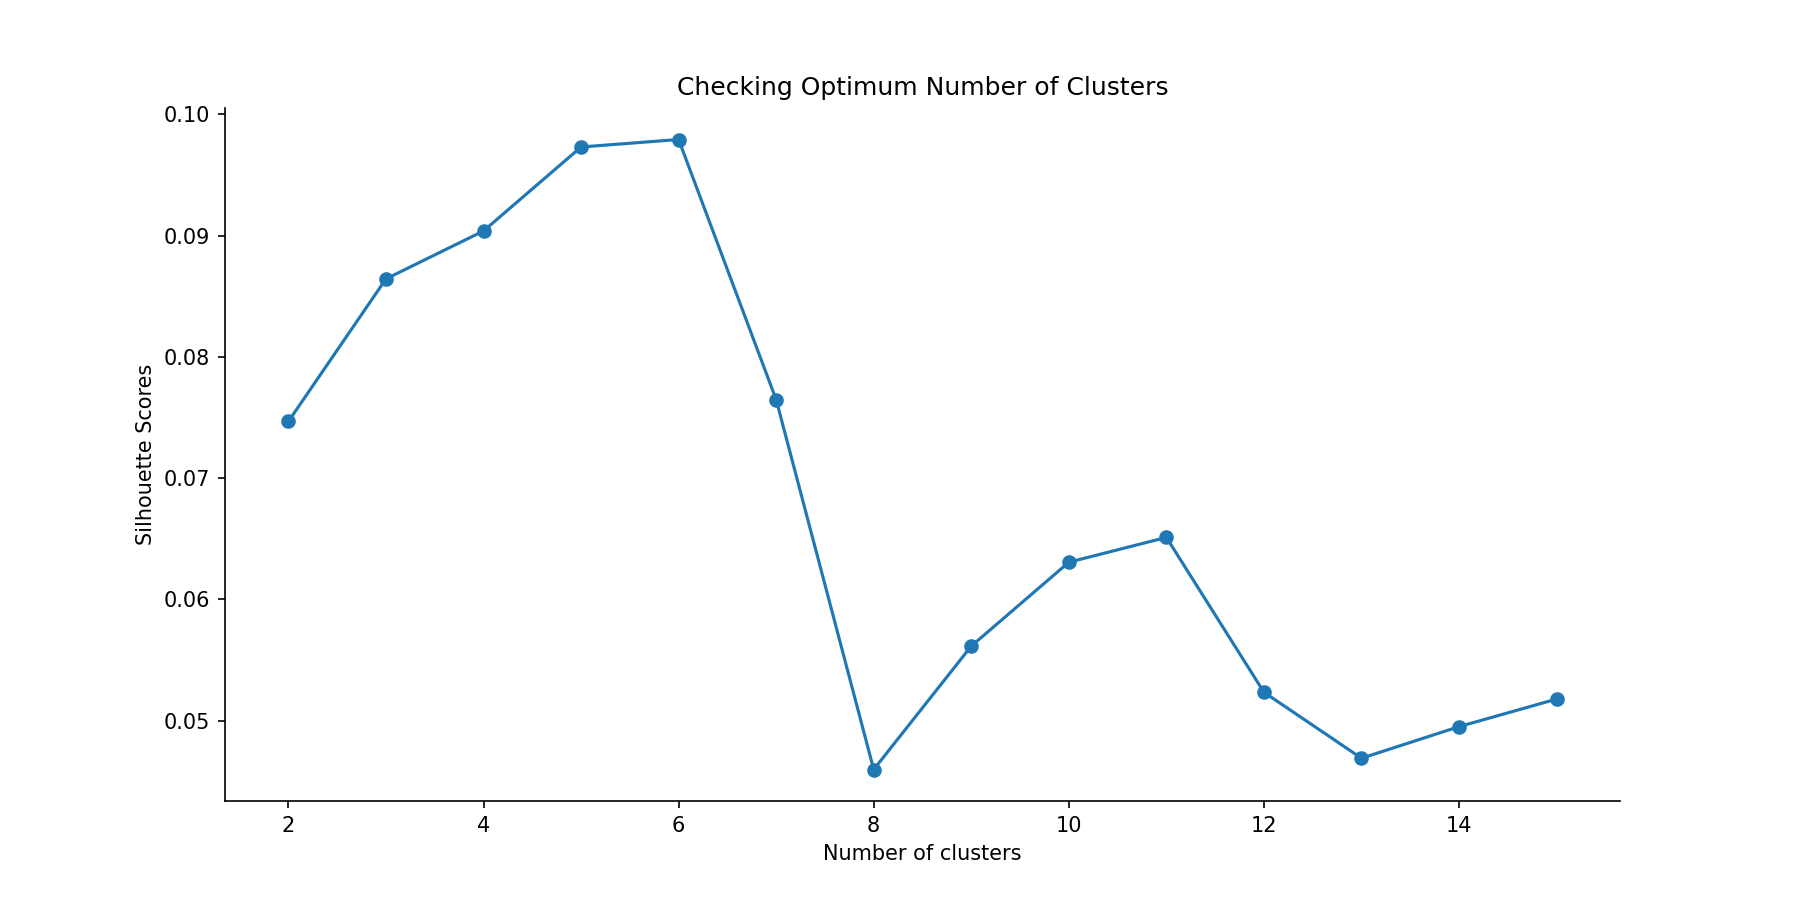

In [50]:
print(scores)
print(kval)
plot(kval, scores)

##### We can see that the silhouette scores are not very high even as we increase the number of clusters. 
##### This means that the inter-cluster distance between different clusters is not very high over the range of k-values. 
##### However, we will try to cluster our data as best as we can. 
##### For this, we will use 5 clusters for our clustering model since it provides the highest silhouette score as seen above.

In [51]:
k = 5

mum_clustering = mum_grouped.drop('Neighborhood', axis=1)
kmeans = KMeans(n_clusters=k, init="k-means++", random_state=40).fit(mum_clustering) #Can choose any random_state

kmeans.labels_

array([1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1,
       2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 0, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1,
       2, 2, 1, 2, 1, 2, 4, 1, 1, 2, 1, 2, 2, 1, 2, 0, 2, 2, 2, 1, 1, 2,
       2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 4, 2, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 3], dtype=int32)

In [52]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
mum_merged = df
mum_merged = mum_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [53]:
print(mum_merged.shape)
mum_merged

(93, 15)


,Neighborhood,Location,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amboli,Western Suburbs,19.1293,72.84644,1,Indian Restaurant,Pizza Place,Coffee Shop,Sandwich Place,Asian Restaurant,Bar,Bowling Alley,Snack Place,Chinese Restaurant,Metro Station
1,Chakala,Western Suburbs,19.10836,72.86233,1,Hotel,Indian Restaurant,Café,Multiplex,Hotel Bar,Pizza Place,Vegetarian / Vegan Restaurant,Asian Restaurant,Fast Food Restaurant,Restaurant
2,D.N. Nagar,Western Suburbs,19.124085,72.83248,2,Bar,Indian Restaurant,Pub,Gym / Fitness Center,Pizza Place,Coffee Shop,Snack Place,Vegetarian / Vegan Restaurant,Lounge,Concert Hall
3,Four Bungalows,Western Suburbs,19.12638,72.8242,2,Pub,Indian Restaurant,Café,Chinese Restaurant,Bar,Ice Cream Shop,Seafood Restaurant,Gym / Fitness Center,Coffee Shop,Pizza Place
4,Lokhandwala,Western Suburbs,19.14321,72.82497,2,Indian Restaurant,Chinese Restaurant,Pub,Café,Bakery,Gym / Fitness Center,Coffee Shop,Italian Restaurant,Bar,Garden
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,Parel,South Mumbai,18.99568,72.84,1,Indian Restaurant,Coffee Shop,Plaza,Bar,Lounge,Maharashtrian Restaurant,Multicuisine Indian Restaurant,Pharmacy,Playground,Chinese Restaurant
89,Gowalia Tank,South Mumbai,18.96446,72.81117,2,Indian Restaurant,Bakery,Coffee Shop,Fast Food Restaurant,Café,Electronics Store,Pizza Place,Snack Place,Restaurant,Sandwich Place
90,Dava Bazaar,South Mumbai,19.1314,72.92696,1,Indian Restaurant,Train Station,Cupcake Shop,Coffee Shop,Café,Beer Garden,Hotel,Restaurant,Shopping Mall,Asian Restaurant
91,Dharavi,Mumbai,19.04674,72.85461,1,Indian Restaurant,Bakery,Gym / Fitness Center,Sandwich Place,Fast Food Restaurant,Lake,Seafood Restaurant,Garden,Diner,Shoe Store


In [54]:
#Map Create

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(mum_merged['Latitude'], mum_merged['Longitude'], mum_merged['Neighborhood'], mum_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Cluster 1

In [55]:
mum_merged.loc[mum_merged['Cluster Labels'] == 0, mum_merged.columns[[0] + [1] + list(range(5, mum_merged.shape[1]))]]

,Neighborhood,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,Nalasopara,Western Suburbs,Multiplex,Bakery,Fast Food Restaurant,Ice Cream Shop,Pizza Place,Diner,Department Store,Music Venue,Music Store,Multicuisine Indian Restaurant
59,Cotton Green,South Mumbai,Plaza,Pizza Place,Fast Food Restaurant,Train Station,Multiplex,Music Venue,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop


## Cluster 2

In [56]:
mum_merged.loc[mum_merged['Cluster Labels'] == 1, mum_merged.columns[[0] + [1] + list(range(5, mum_merged.shape[1]))]]

,Neighborhood,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amboli,Western Suburbs,Indian Restaurant,Pizza Place,Coffee Shop,Sandwich Place,Asian Restaurant,Bar,Bowling Alley,Snack Place,Chinese Restaurant,Metro Station
1,Chakala,Western Suburbs,Hotel,Indian Restaurant,Café,Multiplex,Hotel Bar,Pizza Place,Vegetarian / Vegan Restaurant,Asian Restaurant,Fast Food Restaurant,Restaurant
5,Marol,Western Suburbs,Indian Restaurant,Hotel,Chinese Restaurant,Ice Cream Shop,Coffee Shop,Snack Place,Boat or Ferry,Fast Food Restaurant,Farmers Market,Lounge
9,Mira Road,Western Suburbs,Indian Restaurant,Convenience Store,Bar,Movie Theater,Mexican Restaurant,Multicuisine Indian Restaurant,Fast Food Restaurant,General College & University,Market,Gift Shop
11,Uttan,Western Suburbs,Beach,Convenience Store,Indian Restaurant,Whisky Bar,Restaurant,Accessories Store,Mughlai Restaurant,Music Store,Multiplex,Multicuisine Indian Restaurant
15,I.C. Colony,Western Suburbs,Indian Restaurant,Bakery,Coffee Shop,Fast Food Restaurant,Chinese Restaurant,Bar,Garden Center,Dessert Shop,Paper / Office Supplies Store,Soccer Field
20,Jogeshwari West,Western Suburbs,Indian Restaurant,Snack Place,Asian Restaurant,Ice Cream Shop,Chinese Restaurant,Bank,Hotel,Smoke Shop,Café,Mughlai Restaurant
21,Juhu,Western Suburbs,Indian Restaurant,Movie Theater,Coffee Shop,Fast Food Restaurant,Café,Vegetarian / Vegan Restaurant,Lounge,Department Store,Clothing Store,Restaurant
23,Poisar,Western Suburbs,Train Station,Indian Restaurant,Electronics Store,Snack Place,Mexican Restaurant,Sporting Goods Shop,Bus Line,Diner,Gym / Fitness Center,Breakfast Spot
29,Sunder Nagar,Western Suburbs,Indian Restaurant,Coffee Shop,Movie Theater,Fast Food Restaurant,Bakery,Café,Pizza Place,Restaurant,Breakfast Spot,Food Court


## Cluster 3

In [57]:
mum_merged.loc[mum_merged['Cluster Labels'] == 2, mum_merged.columns[[0] + [1] + list(range(5, mum_merged.shape[1]))]]

,Neighborhood,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,D.N. Nagar,Western Suburbs,Bar,Indian Restaurant,Pub,Gym / Fitness Center,Pizza Place,Coffee Shop,Snack Place,Vegetarian / Vegan Restaurant,Lounge,Concert Hall
3,Four Bungalows,Western Suburbs,Pub,Indian Restaurant,Café,Chinese Restaurant,Bar,Ice Cream Shop,Seafood Restaurant,Gym / Fitness Center,Coffee Shop,Pizza Place
4,Lokhandwala,Western Suburbs,Indian Restaurant,Chinese Restaurant,Pub,Café,Bakery,Gym / Fitness Center,Coffee Shop,Italian Restaurant,Bar,Garden
6,Sahar,Western Suburbs,Indian Restaurant,Hotel,Café,Restaurant,Pizza Place,Seafood Restaurant,Multiplex,Asian Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant
7,Seven Bungalows,Western Suburbs,Café,Bar,Indian Restaurant,Pub,Ice Cream Shop,Seafood Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,Pizza Place
8,Versova,Western Suburbs,Café,Ice Cream Shop,Beach,Coffee Shop,Pizza Place,Chinese Restaurant,Middle Eastern Restaurant,Sandwich Place,Clothing Store,Bistro
10,Bhayandar,Western Suburbs,Ice Cream Shop,Bakery,Food Truck,Indian Restaurant,Pizza Place,Soccer Field,Diner,Train Station,Business Service,Multicuisine Indian Restaurant
12,Bandstand Promenade,Western Suburbs,Coffee Shop,Café,Indian Restaurant,Tea Room,Scenic Lookout,Deli / Bodega,Food Truck,Lounge,Cocktail Bar,Boutique
13,Kherwadi,Western Suburbs,Café,Indian Restaurant,Restaurant,Seafood Restaurant,Bar,Italian Restaurant,Hookah Bar,Chinese Restaurant,Indie Movie Theater,Brazilian Restaurant
14,Pali Hill,Western Suburbs,Indian Restaurant,Bakery,Fast Food Restaurant,Café,Dessert Shop,Italian Restaurant,Bar,Asian Restaurant,Seafood Restaurant,Chinese Restaurant


## Cluster 4

In [58]:
mum_merged.loc[mum_merged['Cluster Labels'] == 3, mum_merged.columns[[0] + [1] + list(range(5, mum_merged.shape[1]))]]

,Neighborhood,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
92,Thane,Mumbai,Playground,Performing Arts Venue,Pizza Place,Music Venue,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater


## Cluster 5

In [59]:
mum_merged.loc[mum_merged['Cluster Labels'] == 4, mum_merged.columns[[0] + [1] + list(range(5, mum_merged.shape[1]))]]

,Neighborhood,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,Mankhurd,Harbour Suburbs,Sports Bar,Coffee Shop,Train Station,Bus Station,Accessories Store,Music Venue,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop
80,Dagdi Chawl,South Mumbai,Coffee Shop,Harbor / Marina,Bus Station,Train Station,Bakery,Flower Shop,Motorcycle Shop,Movie Theater,Music Venue,Moving Target


## Results

In [60]:
new_restaurant_neighborhoods = mum_merged.loc[mum_merged['Cluster Labels'] == 0, mum_merged.columns[[0, 1, 2, 3] + list(range(5, mum_merged.shape[1]))]]
new_restaurant_neighborhoods.head()

,Neighborhood,Location,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,Nalasopara,Western Suburbs,19.42,72.81405,Multiplex,Bakery,Fast Food Restaurant,Ice Cream Shop,Pizza Place,Diner,Department Store,Music Venue,Music Store,Multicuisine Indian Restaurant
59,Cotton Green,South Mumbai,18.986209,72.84121,Plaza,Pizza Place,Fast Food Restaurant,Train Station,Multiplex,Music Venue,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop


In [61]:
map_res_locations = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, location, neighborhood in zip(new_restaurant_neighborhoods['Latitude'], new_restaurant_neighborhoods['Longitude'],
                                            new_restaurant_neighborhoods['Location'], new_restaurant_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, location)
    folium.Marker([lat, lng], popup='{} has geographical coordinates ({:.4f}, {:.4f})'.format(label, lat, lng),
                  icon=folium.Icon(color='lightred'), tooltip=label).add_to(map_res_locations)
    
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_res_locations) 

map_res_locations